# Point source - analytical calculations agree with numerical results. Calculating the wrong thing the right way?

In [132]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project, rotate
from src.interpolate import *

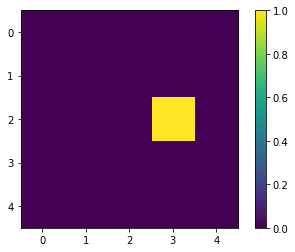

In [134]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

angles = np.array([0,0,np.pi/2])

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:,:,2])
plt.colorbar()

In [135]:
V, X, Y, Z, _, _, _ = volume_fourier(v, dimensions)
#plt.imshow(np.real(v_f[:,:,0])); plt.colorbar()

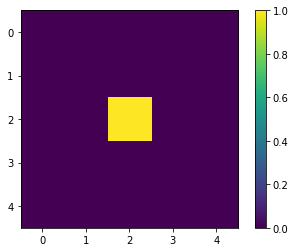

In [136]:
Vs, slice_X, slice_Y, slice_Z = project(V, X, Y, Z, angles, "nn")

Vsi = np.fft.ifftn(Vs)
plt.imshow(np.real(Vsi))
plt.colorbar()

In [137]:
np.imag(Vsi)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

### Step by step inside the project function

In [138]:
# Rotate coordinates

Xr, Yr, Zr = rotate(X, Y, Z, angles)
slice_coords = np.array([Xr[:,:,0].flatten(),Yr[:,:,0].flatten(),Zr[:,:,0].flatten()])

In [139]:
# Get x_freq, etc
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

In [140]:
# Interpolate and reshape
Vr0_flat = interpolate(slice_coords, x_freq, y_freq, z_freq, V, "tri")
Vr0 = Vr0_flat.reshape(5,5)

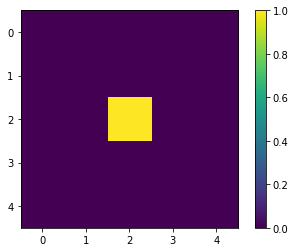

In [141]:
# Inverse Fourier transform
vr0 = np.fft.ifftn(Vr0)
plt.imshow(np.real(vr0))
plt.colorbar()

## The same, analytically

In [142]:
# Fourier transform of a 5 x 5 x 5 cube v with v[3,2,2] = 1 and 0 otherwise.

krange = np.arange(5)
x, y, z = np.meshgrid(krange, krange, krange)
V_a = np.exp(-1j * 2 * np.pi / 5 * (3*x + 2*y + 2*z))
#plt.imshow(np.real(V_a[:,:,0])); plt.colorbar()

In [143]:
# And it's the same as the numerical V

np.max(abs(V - V_a))

1.355199909595506e-15

Given X and Y above, the rotated coordinates of the plane z=0 are

In [144]:
Xr0_a = np.array([np.zeros(5), -1*np.ones(5), -2*np.ones(5), 2*np.ones(5), 1*np.ones(5)])
Xr0_a

array([[ 0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1.],
       [-2., -2., -2., -2., -2.],
       [ 2.,  2.,  2.,  2.,  2.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [145]:
Yr0_a = np.array([0, 1, 2, -2, -1])*np.ones([5,1])
Yr0_a

array([[ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.]])

In [146]:
Zr0_a = np.zeros([5,5])

In [147]:
# And these are also the same as what the function rotate returns

print(np.max(abs(Xr0_a - Xr[:,:,0])))
print(np.max(abs(Yr0_a - Yr[:,:,0])))
print(np.max(abs(Zr0_a - Zr[:,:,0])))

2.220446049250313e-16
2.220446049250313e-16
0.0


In [148]:
# Evaluate V at points given by Xr0_a, Yr0_a, Zr0_a to obtain Vr0_a

Vr0_a = np.exp(-1j * 2 * np.pi/5 * (3 * Xr0_a + 2 * Yr0_a + 2 * Zr0_a))

In [149]:
# And they're the same....WEIRD

np.max(abs(Vr0 - Vr0_a))

6.61269254987238e-16

In [170]:
# Calculate the IFFT 
k_freqs = np.arange(5)
K1, K2 = np.meshgrid(k_freqs, k_freqs)
K3 = np.zeros(K1.shape)

K1r, K2r, K3r = rotate(K1, K2, K3, angles)

vr0_a = np.ones([5,5])*0j
for i in range(5):
    for j in range(5):
        vr0_a[i,j] = 1/25 * np.sum(np.exp(1j * 2 * np.pi / 5 * (i * K1 + j * K2)) * Vr0_a)

        

In [171]:
# Weirdly it's equal with the numerically calculated image
np.max((abs(vr0-vr0_a)))

5.380326543625889e-16

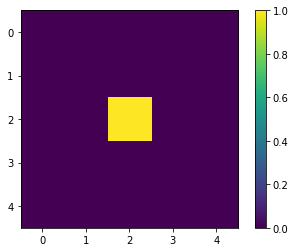

In [172]:
plt.imshow(np.real(vr0_a))
plt.colorbar()

In [180]:
# An even more direct calculation of vr0_a

vr0_a2 = np.zeros([5,5], dtype=np.complex128)
for i in range(5):
    for j in range(5):
        vr0_a2[i,j] = 1/25 * np.sum(np.exp( 1j * 2 * np.pi/5 * ( K1*(i-1) + K2*(j-2)   )))

In [181]:
np.imag(vr0_a2

array([[ 1.77635684e-17-1.33226763e-17j,  2.66453526e-17-4.44089210e-18j,
        -2.66453526e-17-2.66453526e-17j,  1.33226763e-17+0.00000000e+00j,
         1.55431223e-17-4.44089210e-18j],
       [-1.77635684e-17-5.32907052e-17j, -3.55271368e-17-2.22044605e-17j,
         1.00000000e+00+0.00000000e+00j, -3.55271368e-17+2.22044605e-17j,
        -1.77635684e-17+5.32907052e-17j],
       [ 1.55431223e-17+4.44089210e-18j,  1.33226763e-17+0.00000000e+00j,
        -2.66453526e-17+2.66453526e-17j,  2.66453526e-17+4.44089210e-18j,
         1.77635684e-17+1.33226763e-17j],
       [ 0.00000000e+00-1.33226763e-17j,  1.77635684e-17-4.44089210e-18j,
        -1.77635684e-17+4.44089210e-17j,  8.88178420e-18-4.44089210e-18j,
         1.11022302e-17+3.10862447e-17j],
       [ 1.77635684e-17+0.00000000e+00j,  8.88178420e-18+1.33226763e-17j,
         4.44089210e-17+6.66133815e-17j, -2.22044605e-18-4.44089210e-18j,
        -8.88178420e-18+7.79331314e-19j]])